<a href="https://colab.research.google.com/github/sztahodavid/humanaicourse/blob/main/emotion_recognition_speech_wav2vec_tsne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ebben a Demo-ban az érzelmek felismerésével ismerkedhetünk meg beszédből. Az adatbázis 38 beszélőt tartalmaz, akik magyar nyelven a "Kovács Katival szeretnék beszélni" szöveget monták be 8 érzelmi állapot imitálásával. Ezen érzelmek a szomorúság, harag, félelem, izgatottság, undor, megelettség, öröm és semeleges. Jelen esetben a jellzőkinyerést egy mély tanuló algoritmussal végezzük.

Az első lépés a *szükséges csomagok* betöltése.

In [36]:
%%capture
# Local installation
!git clone https://github.com/speechbrain/speechbrain/
%cd /content/speechbrain/
!pip install -r requirements.txt
!pip install -e .

In [37]:
%%capture
# For pip installation
!pip install speechbrain

In [38]:
import os
import pandas as pd
import numpy as np
import torchaudio
import matplotlib.pyplot as plt
from tqdm import tqdm

from speechbrain.inference.interfaces import foreign_class

from sklearn import metrics
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.manifold import TSNE

Ezután az elérési utat adjuk meg az adatbázishoz. Az adatbázist szűrjük a fent leírt beszédmintákra (magyar nyelv és 1. feladat). A célcímkéket eltárolkjuk a *labels* változóban.

In [26]:
!wget http://lsa.tmit.bme.hu/files/HungarianEmotionalSentences.zip
!unzip HungarianEmotionalSentences.zip

--2024-11-25 23:04:58--  http://lsa.tmit.bme.hu/files/HungarianEmotionalSentences.zip
Resolving lsa.tmit.bme.hu (lsa.tmit.bme.hu)... 152.66.246.99
Connecting to lsa.tmit.bme.hu (lsa.tmit.bme.hu)|152.66.246.99|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62600577 (60M) [application/x-zip-compressed]
Saving to: ‘HungarianEmotionalSentences.zip.1’

HungarianEmotionalS 100%[===================>]  59.70M  3.49MB/s    in 11s     

2024-11-25 23:05:11 (5.22 MB/s) - ‘HungarianEmotionalSentences.zip.1’ saved [62600577/62600577]

Archive:  HungarianEmotionalSentences.zip
replace readme.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [27]:
DATA_PATH = "/content/speechbrain/"

file_names = sorted(i for i in os.listdir(DATA_PATH) if i.endswith("_hu.wav") and i[4] == '1')
file_paths = [os.path.join(DATA_PATH, name) for name in file_names]

labels = []
names = []

for name in file_names:
    labels.append(name.split(".")[0].split("_")[0][-1])
    names.append(name.split((".")[0].split("_")[0][-1]))
print("#labels: " + str(len(labels)))
print("#files: " + str(len(names)))

#labels: 262
#files: 262


A címkék a *my_dict* szerinti egy betűs kódolásban vannak a labels *változóban*. Ezeket átalakítjuk számunkra értelmezhetőbb címkékké.

In [28]:
my_dict = {
    'B': "sadness",
    'D': "anger",
    'F': "fear",
    'I': "excitement",
    'L': "disgust",
    'M': "suprise",
    'O': "joy",
    'S': "neutral"
}

for i in range(len(labels)):
    if labels[i] in my_dict:
        labels[i] = my_dict[labels[i]]

In [29]:
classifier = foreign_class(source="speechbrain/emotion-recognition-wav2vec2-IEMOCAP", pymodule_file="custom_interface.py", classname="CustomEncoderWav2vec2Classifier", run_opts={"device":"cuda"})

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:306: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/content/speechbrain/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded vi

A követkző cellában az embedding modell segítségével kinyerjük a jellemzőket. A jellemzőkinyerő algoritmus a pytorch keretrendszerben fut.

In [30]:
embeddings_list = []

for i, file_name in tqdm(enumerate(file_paths)):
    signal, fs = torchaudio.load(file_name)
    embeddings = classifier.encode_batch(signal)
    embeddings_list.append(embeddings.cpu().numpy())

embeddings_array = np.squeeze(np.array(embeddings_list))
print("Shape of array: ", embeddings_array.shape)

262it [00:12, 20.53it/s]

Shape of array:  (262, 768)


A kapott jellemzőket standarizáljuk (z = (x - átlag) / szórás) és eltároljuk az *X* változóban. A címkéket egy *y* tömbben tároljuk el.

In [31]:
scaler = StandardScaler()
scaler.fit(embeddings_array)
X = scaler.transform(embeddings_array)
print(X.shape)

y = np.array(labels)
print(y.shape)

(262, 768)
(262,)


Support Vektor Gép modellt fogunk taníani és tesztelni. Ehhez teljes keresztvalidációs eéjárást alkalmazunk, ahol mindig egy elem a teszt elem, a maradék pedig a tanító halmaz. Ez ismétlődik, amíg az összes elem nem volt tesztelem. Tesztelés során  a minta eredeti címkéjét (*orig*) és a bescült címkét (*pred*) eltároljuk.

In [43]:
loo = LeaveOneOut()
loo.get_n_splits(X)

orig = []
pred = []

for i, (train_index, test_index) in tqdm(enumerate(loo.split(X))):

    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    clf = svm.SVC(kernel = 'linear', C=768, probability=(False))
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)[0]

    orig.append(y_test[0])
    pred.append(y_pred)

262it [00:07, 33.34it/s]


Végül egy *tévesztési mátrixon* és egy *reporton* keresztül vizsgálhatjuk a modellek teljesítményét.

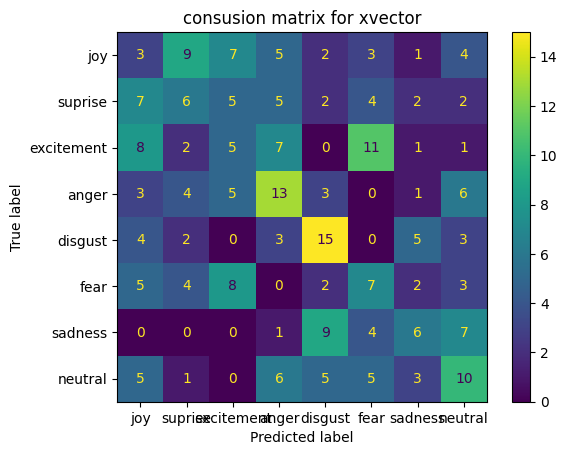

In [40]:
cm = metrics.confusion_matrix(orig, pred, labels=list(set(labels)))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(labels)))
disp.plot()
plt.title('consusion matrix for xvector')
plt.show()

In [41]:
print(metrics.classification_report(orig, pred))

              precision    recall  f1-score   support

       anger       0.33      0.37      0.35        35
     disgust       0.39      0.47      0.43        32
  excitement       0.17      0.14      0.15        35
        fear       0.21      0.23      0.22        31
         joy       0.09      0.09      0.09        34
     neutral       0.28      0.29      0.28        35
     sadness       0.29      0.22      0.25        27
     suprise       0.21      0.18      0.20        33

    accuracy                           0.25       262
   macro avg       0.24      0.25      0.24       262
weighted avg       0.24      0.25      0.24       262



Vizuális betekintést tehetünk a jellemzők szeparációs képességébe úgy, hogy dimenziójukat lecsökkentjük (ábrázolható mennyiségre) a minták egymáshoz képesti távolságuk megtartása mellett (t-SNE: t-distributed stochastic neighbor embedding). Az ábrázoláshoz az érzelmeket színkódoljuk egy szótár segítségével.

Text(0.5, 1.0, 't-SNE of x-vector features')

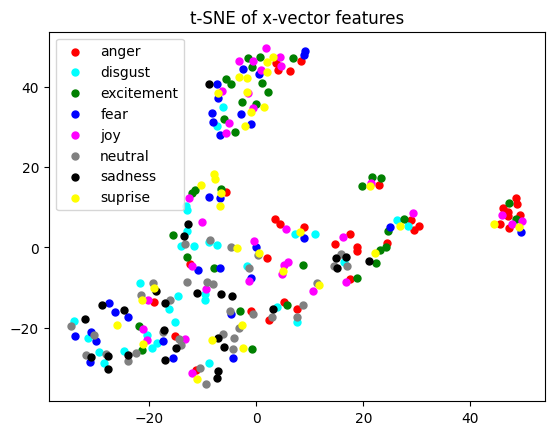

In [42]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(X)

cdict = {
    "sadness": 'black',
    "anger": 'red',
    "fear": 'blue',
    "excitement": 'green',
    "disgust": 'cyan',
    "suprise": 'yellow',
    "joy": 'magenta',
    "neutral": 'gray'
}

for g in np.unique(y):
    ix = np.where(y == g)
    plt.scatter(X_embedded[ix,0], X_embedded[ix,1], c = cdict[g], label = g, s = 25)
plt.legend()
plt.axis('on')
plt.title('t-SNE of x-vector features')